# RL learning and evaluating notebook

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from typing import List, Optional

import numpy as np
import cv2

import torch
import torch.linalg as LA

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from rl_socket import (
    CameraTransition,
    ActorModel,
    CriticModel,
    ActorImprovedValue,
    CriticTD
)

## Initializing initial parameters

### Camera transition

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

camera_mat = torch.tensor([
    [633.09029639, 0., 629.06462963],
    [0., 638.7544391, 362.74013262],
    [0., 0., 1.]
])

target_points = torch.tensor([
    [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]
    ])

points_env = torch.tensor([
    [2, 0, 4],
    [1, 1.66, 4],
    [-1, 1.66, 4],
    [-2, 0, 4],
    [-1, -1.66, 4],
    [1, -1.66, 4],
])

camera_transition = CameraTransition(
    device,
    camera_mat,
    target_points,
    points_env,
)

### Critic's and actor's optimezers

In [3]:
optimizer_critic_kind = torch.optim.Adam
optimizer_critic_parameters = {
    'lr': 5e-6,
    'weight_decay': 1e-5
}

optimizer_actor_kind = torch.optim.Adam
optimizer_actor_parameters = {
    "lr" : 1e-4,
    "weight_decay" : 1e-5
}

critic_iterations = 2000
critic_batch_size = 4000

actor_iterations = 2000
actor_batch_size = 2000

epochs = 5

In [4]:
actor = ActorModel().to(device)
critic = CriticModel().to(device)

critic_temporal_difference = CriticTD(actor, critic, camera_transition).to(device)
actor_improved_value = ActorImprovedValue(actor, critic, camera_transition).to(device)

## Learning methods

In [5]:
def visualize_scatter(orig_coords: np.array,
                      old_coords: np.array,
                      new_coords: np.array,
                      save_dir: Optional[str] = None,
                      image_name: str = 'image') -> None:
    
    plt.scatter( orig_coords[:, 0], orig_coords[:, 1], c=range(6), marker='x')
    plt.scatter( old_coords[:, 0], old_coords[:, 1], c=range(6), marker='o')
    plt.scatter( new_coords[:, 0], new_coords[:, 1], c=range(6), marker='^')
    plt.xlim(-10, 1280)
    plt.ylim(-20, 720)
    if save_dir is not None:
        plt.axis('off')
        plt.savefig(f'{save_dir}\\{image_name}.png')
        plt.axis('on')
    plt.show()

In [6]:
def get_random_position(batch_size: int,
                        linear_min: float = -2.,
                        linear_max: float = 2.,
                        angle_min: float = -.4,
                        angle_max: float = .4):
    return torch.hstack([torch.Tensor(np.random.uniform(linear_min, linear_max, (batch_size, 3)).astype(np.float64)),
                         torch.Tensor(np.random.uniform(angle_min, angle_max, (batch_size, 3)).astype(np.float64))])


def critic_epoch(optimizer: torch.optim.Optimizer,
                 model: CriticTD, 
                 iterations: int, 
                 batch_size: int) -> List[float]:
    losses = []
    for iteration in tqdm(range(iterations), "Critic epoch"):
        X = get_random_position(batch_size).to(device)

        optimizer.zero_grad()
        loss = model(X)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())

    print(f"Critic mean loss: {np.mean(losses)}")
    return losses

def actor_epoch(optimizer: torch.optim.Optimizer,
                 model: CriticTD, 
                 iterations: int, 
                 batch_size: int) -> List[float]:
    values = []
    for iteration in tqdm(range(iterations), "Actor epoch"):
        X = get_random_position(batch_size).to(device)

        optimizer.zero_grad()
        improved_value = model(X)
        improved_value.backward()
        optimizer.step()
        values.append(improved_value.detach().cpu().numpy())
    print(f"Actor mean value: {np.mean(values)}")

    state = X[-1].unsqueeze(0)

    new_state = actor.forward(state)[0]
    ct = camera_transition(state, new_state)
    op = camera_transition._project_points(state).detach().cpu().numpy()
    new = camera_transition._project_points(ct[0]).detach().cpu().numpy()

    visualize_scatter(
        np.array(target_points), 
        np.array(op[0]), 
        np.array(new[0])
    )
    
    return values

## Learning process

Actor-Critic learning:   0%|          | 0/5 [00:00<?, ?it/s]

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 29485380403200.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 5233757.0


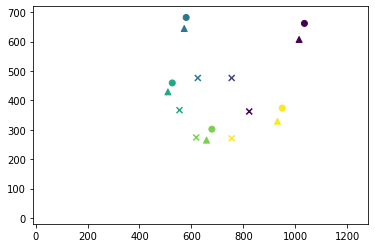

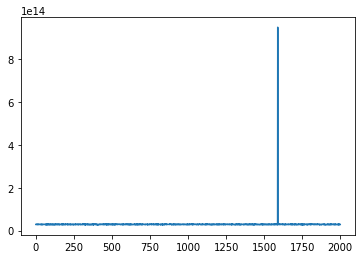

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 27289693716480.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 5224268.5


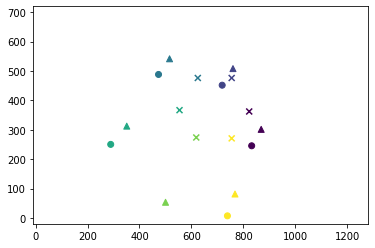

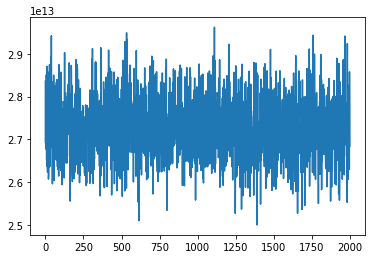

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 27250575540224.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 5220306.0


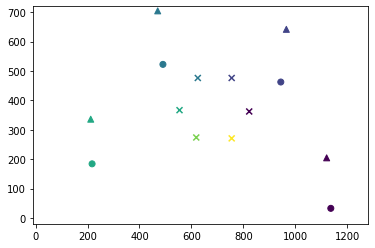

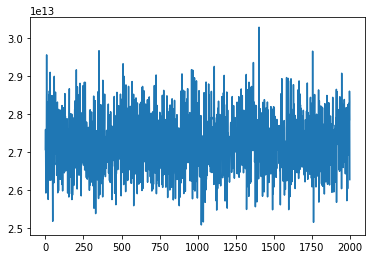

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 27279189082112.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 5222516.5


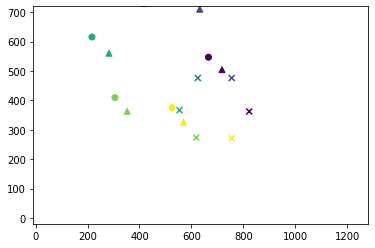

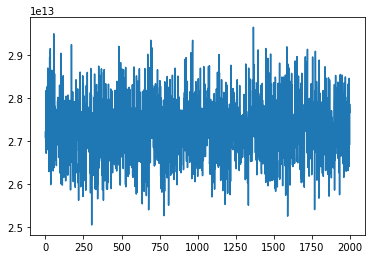

Critic epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Critic mean loss: 27271383482368.0


Actor epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

Actor mean value: 5221162.0


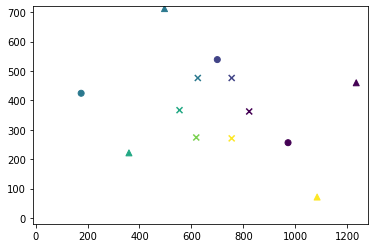

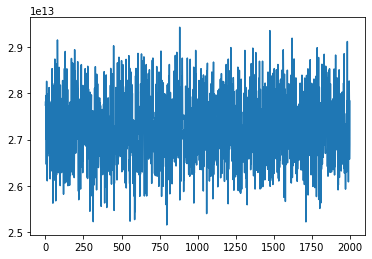

In [7]:
optimizer_actor = optimizer_actor_kind(actor_improved_value.parameters(), **optimizer_actor_parameters)

for _ in tqdm(range(epochs), "Actor-Critic learning", leave=False):
    optimizer_critic = optimizer_critic_kind(critic_temporal_difference.parameters(), **optimizer_critic_parameters)
    losses = np.array(critic_epoch(optimizer_critic,
                                   critic_temporal_difference,
                                   critic_iterations,
                                   actor_batch_size))
    actor_epoch(optimizer_actor,
                actor_improved_value,
                actor_iterations,
                actor_batch_size)
    plt.plot(losses)
    plt.show()

## Testing

Current reward: -1227.8685302734375


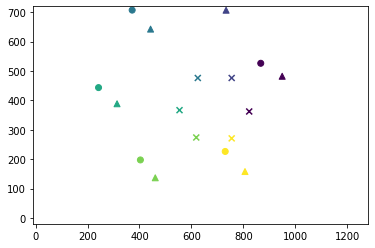

Current reward: -1199.6268310546875


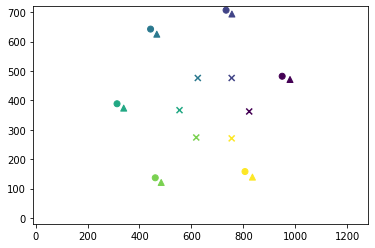

Current reward: -1183.765869140625


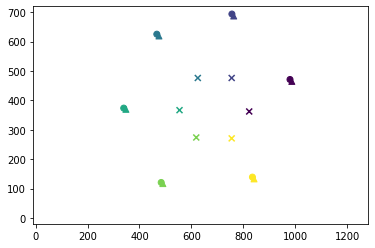

Current reward: -1168.88427734375


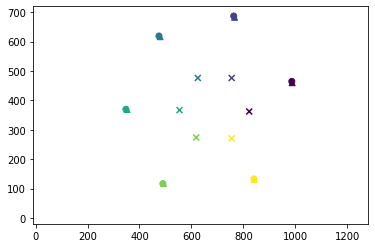

Current reward: -1154.377685546875


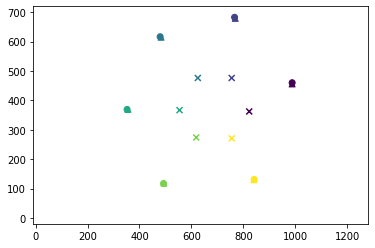

Current reward: -1140.255615234375


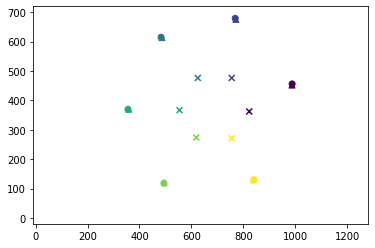

Current reward: -1126.5274658203125


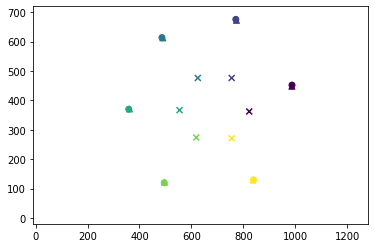

Current reward: -1113.19384765625


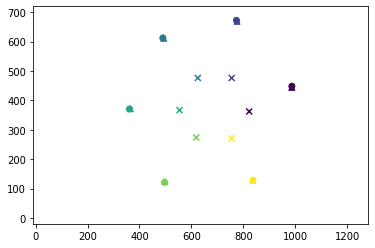

Current reward: -1100.2537841796875


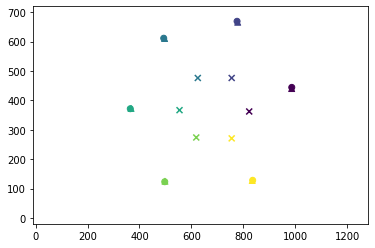

Current reward: -1087.703857421875


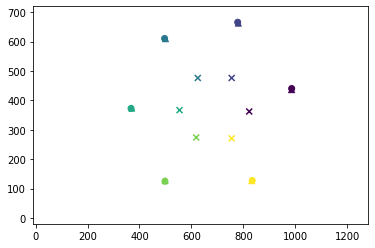

Current reward: -1075.542236328125


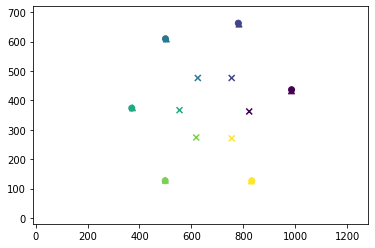

Current reward: -1063.74951171875


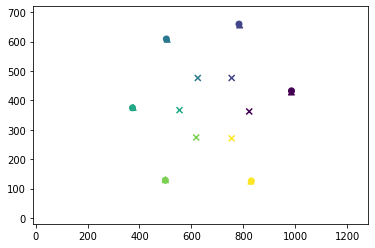

Current reward: -1052.328857421875


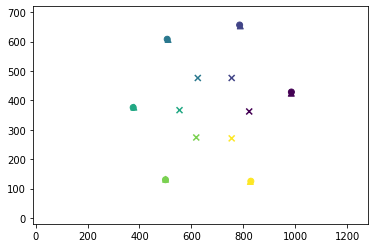

Current reward: -1041.28271484375


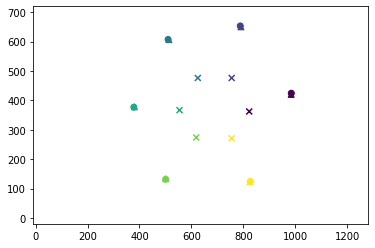

Current reward: -1030.6671142578125


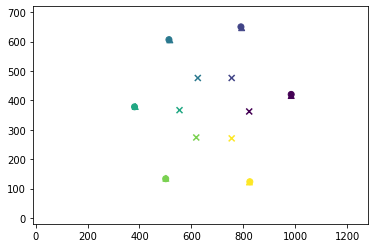

Current reward: -1020.4762573242188


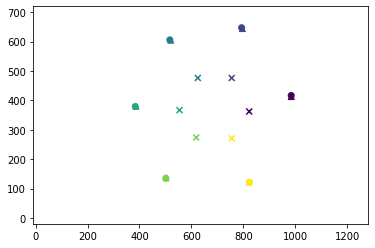

Current reward: -1010.6126708984375


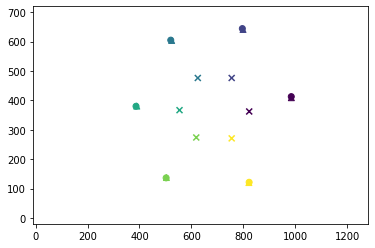

Current reward: -1000.9904174804688


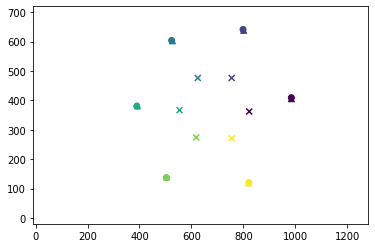

Current reward: -991.599365234375


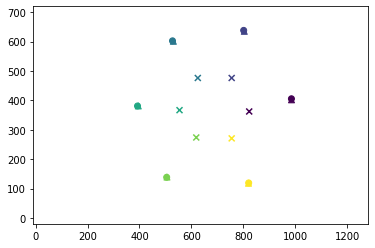

Current reward: -982.4710693359375


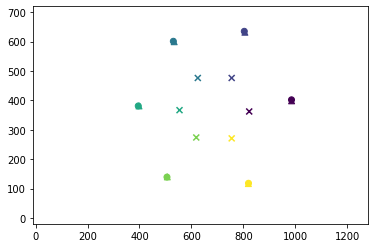

Current reward: -973.4844970703125


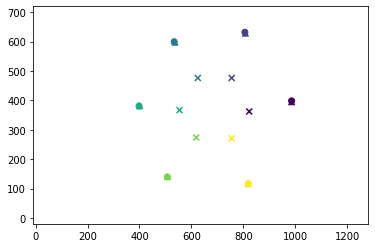

Current reward: -964.4237060546875


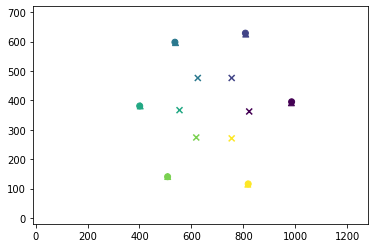

Current reward: -955.5057373046875


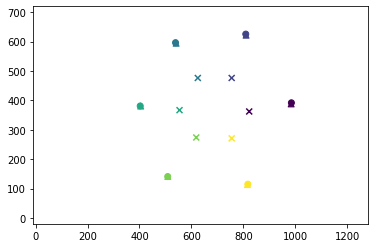

Current reward: -946.721923828125


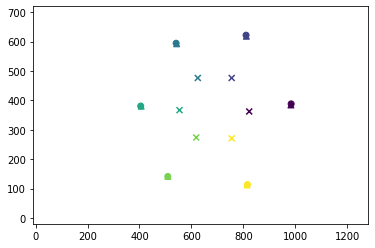

Current reward: -938.0665283203125


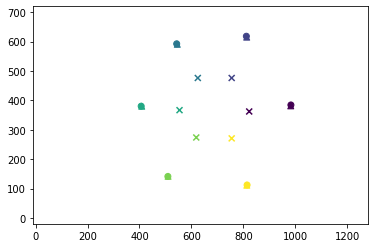

Current reward: -929.517333984375


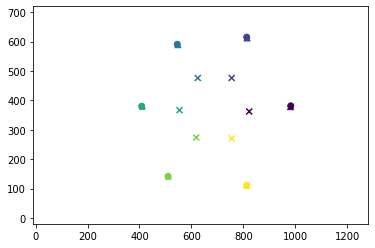

Current reward: -920.8712768554688


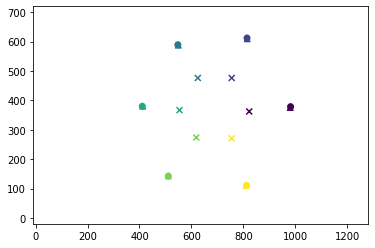

Current reward: -912.3540649414062


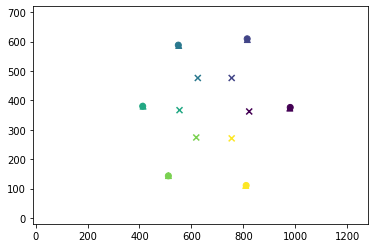

Current reward: -903.8308715820312


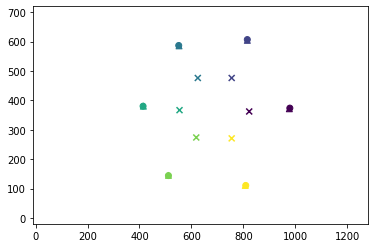

Current reward: -895.2963256835938


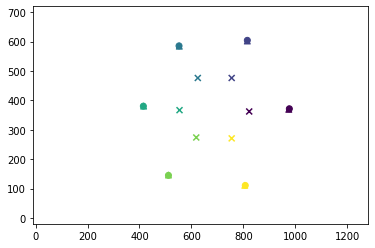

Final state: tensor([[-0.7105,  0.8204,  0.6876, -0.0694,  0.1713,  0.2557]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [8]:
initial_coords = torch.tensor([[-1., 1.1, 0., .1, .1, .1]]).to(device)
iters = 30


state = initial_coords
for _ in range(iters):
    action = actor(state)
    new_state, reward = camera_transition(state, action)
    print(f'Current reward: {reward.detach().cpu().item()}')
    proj = camera_transition._project_points(state).squeeze().detach().cpu()
    new_proj = camera_transition._project_points(new_state).squeeze().detach().cpu()
    
    visualize_scatter(camera_transition.target_points.cpu(), proj, new_proj)
    state = new_state

print(f"Final state: {state}")